# Detecção de Fake News - LSTM

Base de dados usada no projeto: [ISOT Fake News Dataset](https://www.kaggle.com/datasets/emineyetm/fake-news-detection-datasets/data)

## Importa Bibliotecas

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Carrega Dados

In [ ]:
df_train = pd.read_csv('/lstm_train.csv')
df_val = pd.read_csv('/lstm_val.csv')
df_test = pd.read_csv('/lstm_test.csv')

## Preparação dos dados

In [ ]:
# Parâmetros principais
vocab_size = 10000  
max_len = 500 # Tamanho máximo de sequência

In [ ]:
# Junta title + text (se quiser)
train_texts = df_train['title'] + " " + df_train['text']
val_texts = df_val['title'] + " " + df_val['text']
test_texts = df_test['title'] + " " + df_test['text']

# Cria e ajusta tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)  # nunca ajuste no val/test!

# Cria sequências
train_seq = tokenizer.texts_to_sequences(train_texts)
val_seq = tokenizer.texts_to_sequences(val_texts)
test_seq = tokenizer.texts_to_sequences(test_texts)

# Padding com o MESMO max_len
X_train = pad_sequences(train_seq, maxlen=max_len, padding='post', truncating='post')
X_val = pad_sequences(val_seq, maxlen=max_len, padding='post', truncating='post')
X_test = pad_sequences(test_seq, maxlen=max_len, padding='post', truncating='post')

# Labels
y_train = df_train['labels'].values
y_val = df_val['labels'].values
y_test = df_test['labels'].values

# Transforma em tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float)

X_val_tensor = torch.tensor(X_val, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.float)

X_test_tensor = torch.tensor(X_test, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.float)

print(f"X_train: {X_train_tensor.shape}, y_train: {y_train_tensor.shape}")
print(f"X_val: {X_val_tensor.shape}, y_val: {y_val_tensor.shape}")
print(f"X_test: {X_test_tensor.shape}, y_test: {y_test_tensor.shape}")

2025-07-20 04:55:12.324199: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752987312.522755      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752987312.581504      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# Cria TensorDatasets
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds = TensorDataset(X_val_tensor, y_val_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)

# Cria DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

print(f"Tamanho do treino: {len(train_loader.dataset)}")
print(f"Tamanho da validação: {len(val_loader.dataset)}")
print(f"Tamanho do teste: {len(test_loader.dataset)}")

# Funções

In [84]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import torch

class Metrics:
    def __init__(self):
        self.reset()

        # Histórico das métricas (listas)
        self.history_loss = []
        self.history_accuracy = []
        self.history_precision = []
        self.history_recall = []
        self.history_f1 = []
        self.history_auc = []

    def update(self, loss, preds, targets, outputs=None):
        """
        preds, targets: tensores long/int
        outputs: tensor float com scores antes do threshold (para AUC)
        """
        self.total_loss += loss
        self.correct += (preds == targets).sum().item()
        self.total += targets.size(0)

        # Armazena predições e alvos para cálculo das métricas ao final da época
        self.all_preds.extend(preds.cpu().numpy())
        self.all_targets.extend(targets.cpu().numpy())

        # Para AUC, precisamos das probabilidades (sigmoid outputs)
        if outputs is not None:
            probs = torch.sigmoid(outputs).detach().cpu().numpy()
            self.all_probs.extend(probs)

        self.batches += 1

    def compute(self):
        avg_loss = self.total_loss / self.batches if self.batches > 0 else 0
        accuracy = self.correct / self.total if self.total > 0 else 0

        # Calcula precisão, recall, f1 com base em todas as predições acumuladas
        precision = precision_score(self.all_targets, self.all_preds, zero_division=0)
        recall = recall_score(self.all_targets, self.all_preds, zero_division=0)
        f1 = f1_score(self.all_targets, self.all_preds, zero_division=0)

        # AUC precisa de probabilidades, caso contrário None
        try:
            auc = roc_auc_score(self.all_targets, self.all_probs) if len(set(self.all_targets)) > 1 else None
        except:
            auc = None

        # Salva no histórico
        self.history_loss.append(avg_loss)
        self.history_accuracy.append(accuracy)
        self.history_precision.append(precision)
        self.history_recall.append(recall)
        self.history_f1.append(f1)
        self.history_auc.append(auc)

        return {
            'loss': avg_loss,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': auc
        }

    def reset(self):
        self.total_loss = 0.0
        self.correct = 0
        self.total = 0
        self.batches = 0

        self.all_preds = []
        self.all_targets = []
        self.all_probs = []


In [ ]:
def plot_metrics_history(train_metrics, val_metrics):
    """
    Plota o histórico das métricas de treino e validação lado a lado.
    
    Args:
        train_metrics: Metrics (treino)
        val_metrics: Metrics (validação)
    """
    metrics_names = ['loss', 'accuracy', 'precision', 'recall', 'f1', 'auc']
    histories_train = [
        train_metrics.history_loss,
        train_metrics.history_accuracy,
        train_metrics.history_precision,
        train_metrics.history_recall,
        train_metrics.history_f1,
        train_metrics.history_auc
    ]
    histories_val = [
        val_metrics.history_loss,
        val_metrics.history_accuracy,
        val_metrics.history_precision,
        val_metrics.history_recall,
        val_metrics.history_f1,
        val_metrics.history_auc
    ]

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for idx, name in enumerate(metrics_names):
        axes[idx].plot(histories_train[idx], label='Train', marker='o')
        axes[idx].plot(histories_val[idx], label='Validation', marker='x')
        axes[idx].set_title(name.capitalize())
        axes[idx].set_xlabel('Epoch')
        axes[idx].set_ylabel(name.capitalize())
        axes[idx].legend()
        axes[idx].grid(True)

    plt.tight_layout()
    plt.show()

In [79]:
def eval_model(model, criterion, dataloader, metrics):
    model.eval()
    metrics.reset()
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.float().to(device)
            outputs = model(X_batch).squeeze(1)
            loss = criterion(outputs, y_batch)
            preds = (torch.sigmoid(outputs) > 0.5).long()
            targets = y_batch.long()

            metrics.update(loss.item(), preds, targets, outputs)

    results = metrics.compute()
    return results

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, mode='min', delta=0.001, path='best_model.pt'):
        """
        patience: quantas épocas esperar sem melhora
        mode: 'min' para loss, 'max' para accuracy
        delta: mínima diferença para considerar uma melhora real
        path: caminho para salvar o melhor modelo
        """
        self.patience = patience
        self.mode = mode
        self.delta = delta
        self.path = path

        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, metric_value, model):
        # Define sinal: menor ou maior é melhor
        score = -metric_value if self.mode == 'min' else metric_value

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)

## Definição do Modelo

In [120]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout=0.2):
        super(LSTMClassifier, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)                # (batch_size, seq_len, embedding_dim)
        lstm_out, _ = self.lstm(embedded)           # (batch_size, seq_len, hidden_dim)
        lstm_out = lstm_out[:, -1, :]                # Última saída da sequência
        lstm_out = self.dropout(lstm_out)
        out = self.fc(lstm_out)                       # (batch_size, output_dim)
        return out

# Treinamento

In [ ]:
# Hiperparâmetros
embedding_dim = 64
hidden_dim = 128
output_dim = 1
learning_rate = 0.0008
weight_decay=0
dropout=0.2
patience = 8

In [122]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMClassifier(vocab_size, embedding_dim=128, hidden_dim=64, output_dim=1, dropout=dropout)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= learning_rate, weight_decay=weight_decay)

In [82]:
def train_epoch(model, dataloader, criterion, optimizer, metrics):
    model.train()
    metrics.reset()
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.float().to(device)

        optimizer.zero_grad()
        outputs = model(X_batch).squeeze(1)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        preds = (torch.sigmoid(outputs) > 0.5).long()
        targets = y_batch.long()

        metrics.update(loss.item(), preds, targets, outputs)

    results = metrics.compute()
    return results  # dict

In [123]:
early_stopping = EarlyStopping(patience=10, mode='min', path='best_lstm.pt')

train_metrics = Metrics()
val_metrics = Metrics()
epochs = 60

for epoch in range(epochs):
    train_results = train_epoch(model, train_loader, criterion, optimizer, train_metrics)
    val_results = eval_model(model, criterion, val_loader, val_metrics)

    val_loss = val_results['loss']
    val_acc = val_results['accuracy']

    print(f"Epoch {epoch+1}: Train Loss={train_results['loss']:.4f} | Val Loss={val_loss:.4f} | Val Acc={val_acc:.4f}")

    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping acionado!")
        break

model.load_state_dict(torch.load('best_lstm.pt'))


Epoch 1: Train Loss=120.0904 | Val Loss=119.5385 | Val Acc=0.4703
Epoch 2: Train Loss=119.7138 | Val Loss=119.2785 | Val Acc=0.5536
Epoch 3: Train Loss=110.6558 | Val Loss=103.3703 | Val Acc=0.9382
Epoch 4: Train Loss=102.3081 | Val Loss=101.2401 | Val Acc=0.9587
Epoch 5: Train Loss=101.0229 | Val Loss=101.2598 | Val Acc=0.9506
Epoch 6: Train Loss=100.6293 | Val Loss=102.6661 | Val Acc=0.9576
Epoch 7: Train Loss=100.1647 | Val Loss=101.0905 | Val Acc=0.9629
Epoch 8: Train Loss=99.4211 | Val Loss=100.8068 | Val Acc=0.9623
Epoch 9: Train Loss=102.2727 | Val Loss=104.2003 | Val Acc=0.8740
Epoch 10: Train Loss=99.9719 | Val Loss=100.7605 | Val Acc=0.9654
Epoch 11: Train Loss=98.7529 | Val Loss=100.3687 | Val Acc=0.9644
Epoch 12: Train Loss=98.6847 | Val Loss=101.5669 | Val Acc=0.9690
Epoch 13: Train Loss=99.4258 | Val Loss=100.9859 | Val Acc=0.9634
Epoch 14: Train Loss=98.4493 | Val Loss=100.9056 | Val Acc=0.9686
Epoch 15: Train Loss=98.1372 | Val Loss=101.3623 | Val Acc=0.9663
Epoch 16: T

<All keys matched successfully>

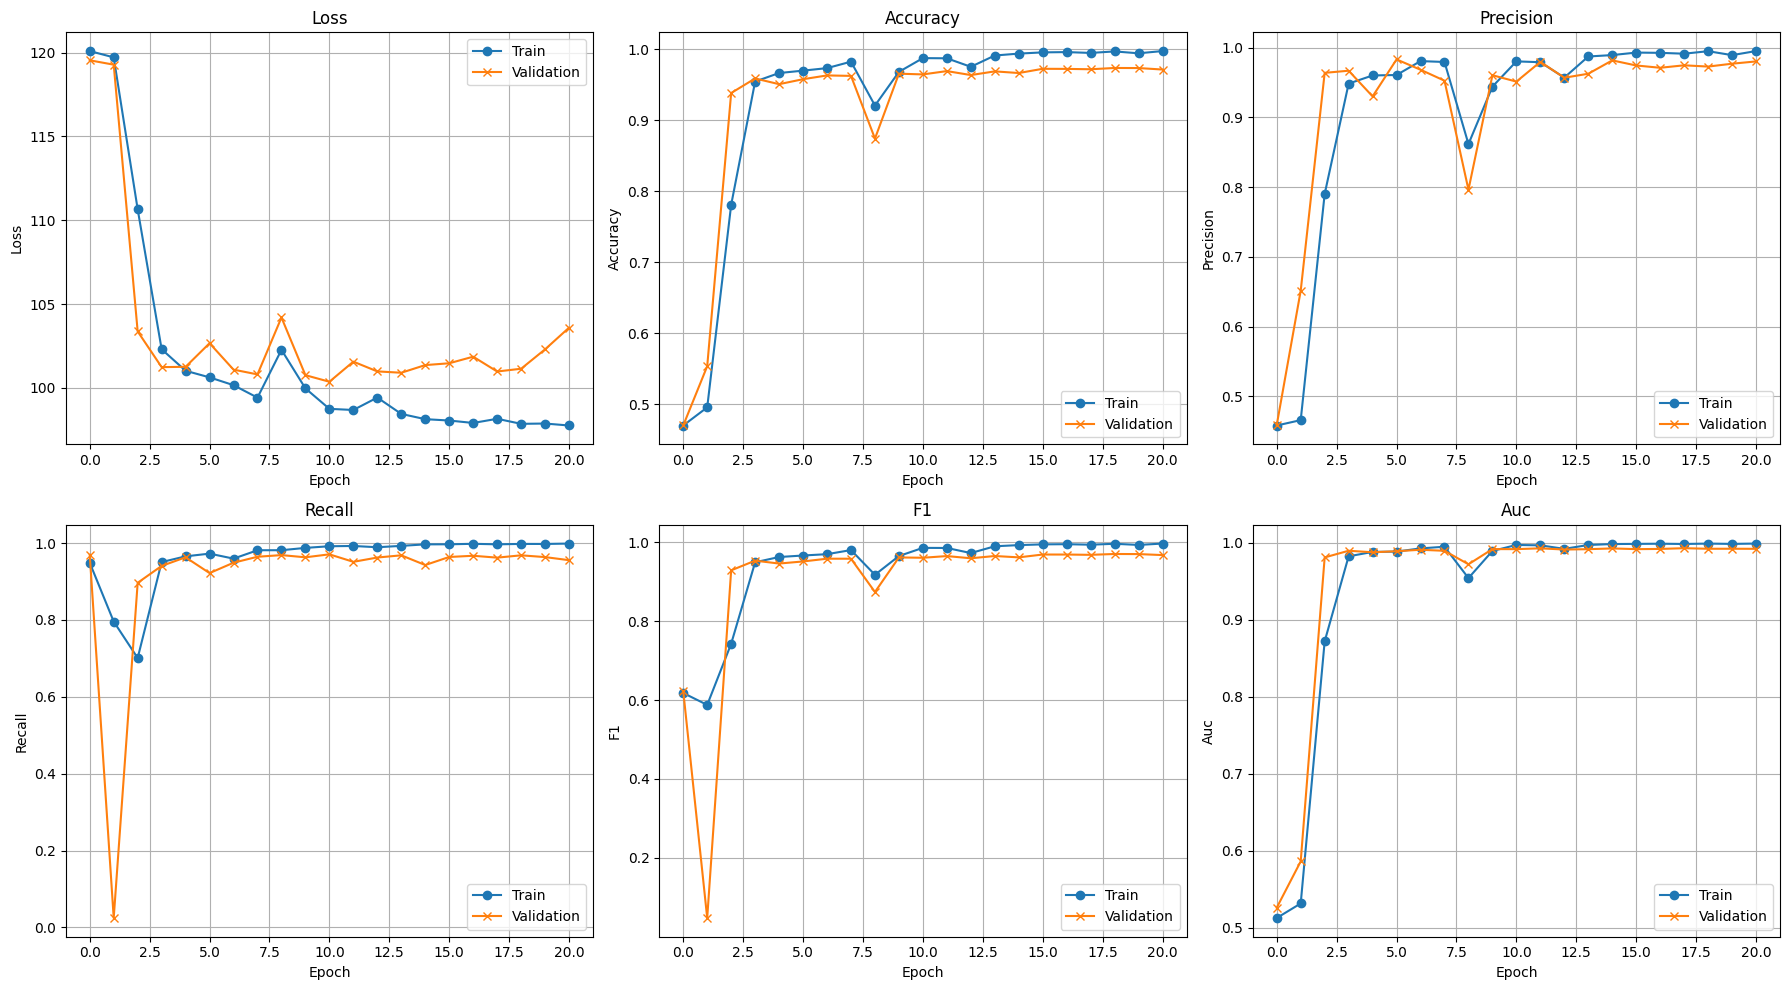

In [124]:
plot_metrics_history(train_metrics, val_metrics)

## Avaliação do Modelo

In [ ]:
def test_model(model, dataloader, criterion):
    model.eval()
    metrics = Metrics()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.float().to(device)
            outputs = model(X_batch).squeeze(1)
            loss = criterion(outputs, y_batch)
            preds = (torch.sigmoid(outputs) > 0.5).long()
            targets = y_batch.long()

            metrics.update(loss.item(), preds, targets, outputs)

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    results = metrics.compute()
    return results, all_preds, all_targets


In [126]:
test_results, y_pred, y_true = test_model(model, test_loader, criterion)

print("Test Results:")
for k, v in test_results.items():
    print(f"{k}: {v:.4f}")

Test Results:
loss: 99.6371
accuracy: 0.9670
precision: 0.9565
recall: 0.9705
f1: 0.9635
auc: 0.9924


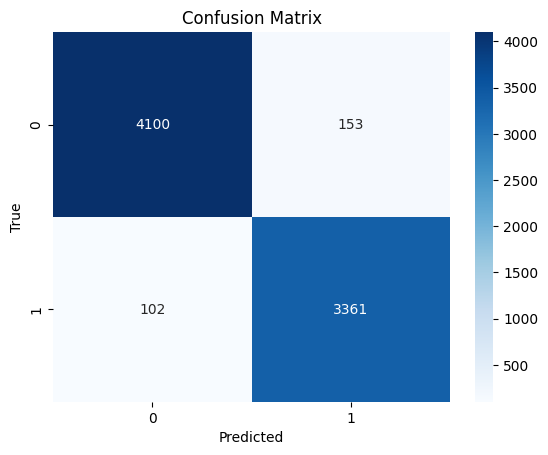

In [127]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion(y_true, y_pred)